In [1]:
import numpy as np
import pandas as pd
from itertools import product
import tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, SGDRegressor, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


import lightgbm as lgb

%matplotlib inline


RANDOM_STATE = 42

### Load Data

In [2]:
#train = pd.read_hdf("data/sales_train.h5", 'df')
train = pd.read_csv("data/sales_train_v2.csv")
train['date'] = list(map(lambda x: pd.datetime.strptime(str(x), '%d.%m.%Y'), train['date'].values))        
test = pd.read_csv("data/test.csv")
sample = pd.read_csv("data/sample_submission.csv")
items = pd.read_csv("data/items.csv")
item_categories = pd.read_csv("data/item_categories.csv")
print(f"train{train.shape}, test{test.shape}, sample{sample.shape}, items{items.shape}, item_categories{item_categories.shape}")

train(2935849, 6), test(214200, 3), sample(214200, 2), items(22170, 3), item_categories(84, 2)


In [9]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


### Check NaNs

In [7]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [8]:
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

### Naive model

In [8]:
train["item_cnt_day"] = train["item_cnt_day"].apply(lambda x: 0 if x < 0 else x)
train["item_cnt_day"] = train["item_cnt_day"].apply(lambda x: 20 if x > 20 else x)

#### Monthly mean target

In [17]:
mean_df = train.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].agg(np.mean).to_frame()
mean_df["shop_id"] = mean_df.index.get_level_values(0)
mean_df["item_id"] = mean_df.index.get_level_values(1)
mean_df["date_block_num"] = mean_df.index.get_level_values(2)
mean_df = mean_df.reset_index(drop=True)
mean_df.head()

,item_cnt_day,shop_id,item_id,date_block_num
0,3.444444,0,30,1
1,1.571429,0,31,1
2,1.500000,0,32,0
3,1.428571,0,32,1
4,1.000000,0,33,0


In [58]:
max_month_df = mean_df.groupby(["shop_id","item_id"]).\
apply(lambda x: x[x["date_block_num"]==x["date_block_num"].max()]["item_cnt_day"].values[0])
max_month_df.shape

(424124,)

In [67]:
max_month_df = max_month_df.to_frame()
max_month_df.columns = ["pred"]
max_month_df["shop_id"] = max_month_df.index.get_level_values(0)
max_month_df["item_id"] = max_month_df.index.get_level_values(1)
max_month_df = max_month_df.reset_index(drop=True)
max_month_df.head()

,pred,shop_id,item_id
0,3.444444,0,30
1,1.571429,0,31
2,1.428571,0,32
3,1.000000,0,33
4,1.272727,0,35


#### Submit Naive model

In [6]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [90]:
test_new = pd.merge(test, max_month_df, how="left", on=["shop_id","item_id"])
test_new.shape

(214200, 4)

In [92]:
test_new["pred"].fillna(0, inplace=True)
test_new["pred"].isnull().sum()

0

In [93]:
sample["item_cnt_month"] = test_new["pred"].values
sample.head()

,ID,item_cnt_month
0,0,1.0
1,1,0.0
2,2,1.0
3,3,1.0
4,4,0.0


In [89]:
sample.to_csv("previous_value_benchmark.csv", index=False)

## EDA

In [3]:
train["item_cnt_day"] = train["item_cnt_day"].apply(lambda x: 0 if x < 0 else x)
train["item_cnt_day"] = train["item_cnt_day"].apply(lambda x: 20 if x > 20 else x)

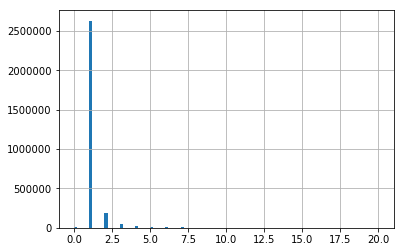

In [4]:
train["item_cnt_day"].hist(bins=100);

In [5]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,0.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [37]:
train['item_cnt_day'].min()

0.0

In [11]:
np.isin(test["shop_id"].unique(), train["shop_id"].unique()).sum()

42

In [16]:
pd.merge(test,train, how="left", on=['shop_id', 'item_id']).shape

(1327235, 7)

In [18]:
test.shape, train.shape

((214200, 3), (2935849, 6))

### Features generation

#### Make table for all combination 'shop_id', 'item_id'

In [38]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in tqdm.tqdm_notebook(train['date_block_num'].unique()):
    cur_shops = train[train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = train[train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid.shape

(10913850, 3)

In [3]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

In [4]:
train['month'] = train['date'].apply(lambda x: x.month)
train['year'] = train['date'].apply(lambda x: x.year)

#get aggregated values for (shop_id, item_id, month)
def get_mnth(series):
    return pd.to_datetime(series.values[0]).month
def get_year(series):
    return pd.to_datetime(series.values[0]).year

gb = train.groupby(index_cols,as_index=False).agg({'item_price':{'item_price_sum':'sum',
                                                                 'item_price_mean':'mean'
                                                                },
                                                   'month': {'month':'max'},
                                                   'year':  {'year':'max'},
                                                   'item_cnt_day':{'target':'sum'}
                                                  })

#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#join aggregated data to the grid

#all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
all_data = gb.fillna(0)

#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

all_data.shape

/home/bulat/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


(1609124, 8)

In [31]:
# Save all data
all_data.to_hdf("data/all_data.h5",'df',table=True)

### <font color="green"> Read all_data </font>

In [3]:
all_data = pd.read_hdf("data/all_data.h5",'df')
all_data.fillna(0, inplace=True)
all_data.shape

(1609124, 8)

In [4]:
all_data.head()

,shop_id,item_id,date_block_num,item_price_sum,item_price_mean,month,year,target
2,0,32,0,884.0,221.0,1,2013,6.0
4,0,33,0,1041.0,347.0,1,2013,3.0
6,0,35,0,247.0,247.0,1,2013,1.0
11,0,43,0,221.0,221.0,1,2013,1.0
13,0,51,0,257.0,128.5,1,2013,2.0


### Make pivot with target

In [5]:
pivot_df = all_data.pivot_table(index=["shop_id","item_id"], columns='date_block_num', 
                                values='target', aggfunc='sum', fill_value=0)
pivot_df.shape

(424124, 34)

In [6]:
pivot_df.head()

date_block_num   0   1   2   3   4   5   6   7   8   9  ...  24  25  26  27  \
shop_id item_id                                         ...                   
0       30        0  31   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        31        0  11   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        32        6  10   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        33        3   3   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        35        1  14   0   0   0   0   0   0   0   0 ...   0   0   0   0   

date_block_num   28  29  30  31  32  33  
shop_id item_id                          
0       30        0   0   0   0   0   0  
        31        0   0   0   0   0   0  
        32        0   0   0   0   0   0  
        33        0   0   0   0   0   0  
        35        0   0   0   0   0   0  

[5 rows x 34 columns]

In [7]:
new_df = pd.DataFrame(pivot_df.to_records())
new_df.columns = ["shop_id","item_id"] + ['lag_'+str(i) for i in new_df.columns[2:]]
new_df = new_df.rename(index=str, columns={"lag_33":"target"})
new_df.head()

,shop_id,item_id,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,target
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get window target feats

In [8]:
df_final = new_df[list(new_df.columns[:2]) + list(new_df.columns[-7:])].copy()
#df_final = new_df.copy()
for w in tqdm.tqdm_notebook([6,12,24,32]):
    df_roll = new_df[new_df.columns[2:-1]].T.rolling(w).mean().T.dropna(how="all", axis=1)
    df_roll.columns = ['tg_mean_'+str(w)+'_'+str(i) for i in range(df_roll.shape[1])]
    df_final = pd.concat([df_final, df_roll], axis=1)
df_final.shape

(424124, 71)

In [107]:
df_final.head()

,shop_id,item_id,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,tg_mean_24_2,tg_mean_24_3,tg_mean_24_4,tg_mean_24_5,tg_mean_24_6,tg_mean_24_7,tg_mean_24_8,tg_mean_24_9,tg_mean_32_0,tg_mean_32_1
0,0,30,0,31,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.96875,0.96875
1,0,31,0,11,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.34375,0.34375
2,0,32,6,10,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50000,0.31250
3,0,33,3,3,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.18750,0.09375
4,0,35,1,14,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.46875,0.43750


#### Get other feats from all_data

In [9]:
df_lst = []
for f in tqdm.tqdm_notebook(['item_price_sum','item_price_mean']):
    
    pivot_df = all_data.pivot_table(index=["shop_id","item_id"], columns='date_block_num', 
                                    values=f, aggfunc='sum', fill_value=0)
    
    df_ = pd.DataFrame(pivot_df.to_records())
    df_.columns = ["shop_id","item_id"] + [f+'_lag_'+str(i) for i in df_.columns[2:]]
    df_ = df_.drop(df_.columns[-1], axis=1)
    
    df_i = df_[list(df_.columns[:2]) + list(df_.columns[-7:])].copy()
    for w in tqdm.tqdm_notebook([24,32]):
        df_roll = df_[df_.columns[2:]].T.rolling(w).mean().T.dropna(how="all", axis=1)
        df_roll.columns = [f[-9:]+'_'+str(w)+'_'+str(i) for i in range(df_roll.shape[1])]
        df_i = pd.concat([df_i, df_roll], axis=1)
    
    df_lst.append(df_i)

#### Merge DF with target lags with DF with other features

In [10]:
for df in tqdm.tqdm_notebook(df_lst):
    df_final = pd.merge(df_final, df, how="left", on=["shop_id","item_id"])
df_final.shape

(424124, 109)

### Split train/test

In [14]:
X = df_final.drop(['shop_id', 'item_id', 'target'], axis=1)
y = df_final['target']
indices = range(X.shape[0])
X_train, X_valid, y_train, y_valid, idx_trn, idx_vld = train_test_split(X, y, indices, 
                                                                        test_size=0.2, shuffle=True,
                                                                        random_state=RANDOM_STATE)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((339299, 106), (84825, 106), (339299,), (84825,))

### Encode categorical features
- Expanding mean scheme

In [21]:
def expand_encode(df_trn, df_val, cat_lst):
    for f in tqdm.tqdm_notebook(cat_lst):
        # train set
        cumsum = df_trn.groupby(f)['target'].cumsum() - df_trn['target']
        cumcnt = df_trn.groupby(f).cumcount()
        df_trn[f+'_trgt_expand'] = cumsum/cumcnt
        df_trn[f+'_trgt_expand'] = df_trn[f+'_trgt_expand'].fillna(df_trn['target'].mean())

        # test set
        cumsum_tst = df_val[f].map(cumsum)
        cumcnt_tst = df_val[f].map(cumcnt)
        df_val[f+'_trgt_expand'] = cumsum_tst/cumcnt_tst
        df_val[f+'_trgt_expand'] = df_val[f+'_trgt_expand'].fillna(df_trn['target'].mean())
        
    return df_trn, df_val

In [22]:
df_trn = df_final.iloc[idx_trn].copy()
df_val = df_final.iloc[idx_vld].copy()
cat_lst = ['shop_id', 'item_id']
df_trn, df_val = expand_encode(df_trn, df_val, cat_lst)

/home/bulat/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/bulat/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/bulat/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [32]:
X = pd.concat([df_trn,df_val], axis=1).drop(['shop_id', 'item_id', 'target'], axis=1) 
y = pd.concat([df_trn,df_val], axis=1)['target']
X_train = df_trn.drop(['shop_id', 'item_id', 'target'], axis=1) 
X_valid = df_val.drop(['shop_id', 'item_id', 'target'], axis=1)  
y_train = df_trn['target'] 
y_valid = df_val['target'] 

## Modeling

### Linear model

In [34]:
sgd = make_pipeline(StandardScaler(), LinearRegression())
sgd.fit(X_train, y_train)
sgd_pred = sgd.predict(X_valid)
print('rmse:{}'.format(round(np.sqrt(mean_squared_error(y_valid, sgd_pred)),4)))

rmse:2.23


### RandomForest

In [39]:
%%time
rf = RandomForestRegressor( n_estimators = 100,
                            max_depth = 20,
                            random_state=RANDOM_STATE, 
                            n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
print('rmse:{}'.format(round(np.sqrt(mean_squared_error(y_valid, rf_pred)),4)))

rmse:1.1171
CPU times: user 44min 36s, sys: 2.68 s, total: 44min 39s
Wall time: 11min 39s


### LightGBM

In [ ]:
lgb_params = {   'learning_rate': 0.01,
                 'max_depth': 6,
                 'min_data_in_leaf': 5,
                 'n_estimators': 1500,
                 'num_leaves': 50,
                 #'reg_alpha': params['reg_alpha'],
                 #'reg_lambda': params['reg_lambda'],
                 'objective': 'mse',
                 'random_state': RANDOM_STATE,
                 'n_jobs': -1,
              
             }

In [ ]:
%%time
lgbm = lgb.LGBMRegressor(**lgb_params)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_valid)
print('rmse:{}'.format(round(np.sqrt(mean_squared_error(y_valid, y_pred)),4)))

## Submit

In [ ]:
lgbm = lgb.LGBMRegressor(**lgb_params)
lgbm.fit(X, y)
lgb_pred = lgbm.predict(X_valid)